In [69]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [89]:
ingredient_to_category = {
    # Nuts
    "peanuts": "Nuts",
    "cashew": "Nuts",
    "chestnuts": "Nuts",
    "pistachios": "Nuts",
    "almond": "Nuts",
    "hazelnut": "Nuts",
    "walnuts": "Nuts",
    "pecans": "Nuts",
    "brazil_nut": "Nuts",
    "pili_nut": "Nuts",
    
    # Spices
    "cumin": "Spices",
    "star_anise": "Spices",
    "nutmeg": "Spices",
    "cloves": "Spices",
    "ginger": "Spices",
    "allspice": "Spices",
    "chervil": "Spices",
    "mustard": "Spices",
    "cinnamon": "Spices",
    "saffron": "Spices",
    
    # Herbs
    "angelica": "Herbs",
    "garlic": "Herbs",
    "chives": "Herbs",
    "turnip": "Herbs",
    "dill": "Herbs",
    "mugwort": "Herbs",
    "chamomile": "Herbs",
    "coriander": "Herbs",
    "oregano": "Herbs",
    "mint": "Herbs",
    
    # Fruits
    "kiwi": "Fruits",
    "pineapple": "Fruits",
    "banana": "Fruits",
    "lemon": "Fruits",
    "mandarin_orange": "Fruits",
    "strawberry": "Fruits",
    "apple": "Fruits",
    "mango": "Fruits",
    "peach": "Fruits",
    "pear": "Fruits",
    
    # Vegetables
    "cauliflower": "Vegetables",
    "brussel_sprouts": "Vegetables",
    "broccoli": "Vegetables",
    "sweet_potato": "Vegetables",
    "asparagus": "Vegetables",
    "avocado": "Vegetables",
    "radish": "Vegetables",
    "tomato": "Vegetables",
    "potato": "Vegetables",
    "cabbage": "Vegetables",
}


In [90]:
training_data = defaultdict(list)
testing_data = defaultdict(list)

training_path = "/Users/derre/Documents/workspace/smell-net/training"
testing_path = "/Users/derre/Documents/workspace/smell-net/testing"
min_len = float('inf')  # Track minimum length across all series

# Walk through the training directory
for folder_name in os.listdir(training_path):
    folder_path = os.path.join(training_path, folder_name)
    
    if os.path.isdir(folder_path):  # Make sure it's a folder
        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                cur_path = os.path.join(folder_path, filename)
                df = pd.read_csv(cur_path)
                training_data[folder_name].append(df)
                min_len = min(min_len, df.shape[0])  # Update minimum length

for folder_name in os.listdir(testing_path):
    folder_path = os.path.join(testing_path, folder_name)
    
    if os.path.isdir(folder_path):  # Make sure it's a folder
        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                cur_path = os.path.join(folder_path, filename)
                df = pd.read_csv(cur_path)
                testing_data[folder_name].append(df)
                min_len = min(min_len, df.shape[0])  # Update minimum length

In [91]:
for folder_name in os.listdir(training_path):
    if folder_name.split(".")[0] not in ingredient_to_category:
        print(folder_name)

In [92]:
aggregated_training = []
aggregated_testing = []

# Aggregate training data
for ingredient, dfs in training_data.items():
    for i, df in enumerate(dfs):
        df = df.copy()  # Safe copy
        df['ingredient'] = ingredient
        df['file_id'] = f"{ingredient}_train_{i}"
        df['time_step'] = range(len(df))
        aggregated_training.append(df)

# Aggregate testing data
for ingredient, dfs in testing_data.items():
    for i, df in enumerate(dfs):
        df = df.copy()
        df['ingredient'] = ingredient
        df['file_id'] = f"{ingredient}_test_{i}"
        df['time_step'] = range(len(df))
        aggregated_testing.append(df)

# Concatenate into final DataFrames
aggregated_training = pd.concat(aggregated_training, ignore_index=True)
aggregated_testing = pd.concat(aggregated_testing, ignore_index=True)

# Map the ingredient to category
aggregated_training['category'] = aggregated_training['ingredient'].map(ingredient_to_category)
aggregated_testing['category'] = aggregated_testing['ingredient'].map(ingredient_to_category)

# Check a few examples
print(aggregated_training[['ingredient', 'category']].drop_duplicates().head())

      ingredient category
0        mugwort    Herbs
2850       apple   Fruits
5921      turnip    Herbs
8909        pear   Fruits
12112    chervil   Spices


In [30]:
# Select only the sensor columns (exclude ingredient, file_id, time_step)
sensor_columns = [
    'NO2', 'C2H5OH', 'VOC', 'CO', 'Alcohol', 'LPG', 'Benzene',
    'Temperature', 'Pressure', 'Humidity', 'Gas_Resistance', 'Altitude'
]

# 1. Overall summary (across all training samples)
training_summary = aggregated_training[sensor_columns].describe().round(3)
testing_summary = aggregated_testing[sensor_columns].describe().round(3)

print("Training Data Summary:")
print(training_summary)

print("\nTesting Data Summary:")
print(testing_summary)


Training Data Summary:
              NO2      C2H5OH         VOC          CO     Alcohol         LPG  \
count  150711.000  150711.000  150711.000  150711.000  150711.000  150711.000   
mean       97.795     138.328     195.943     792.938       3.407      30.333   
std       118.680     143.402     196.188      61.667       3.279      38.286   
min        13.000      39.000      26.000     705.000       0.000       2.000   
25%        35.000      65.000      73.000     750.000       1.000      14.000   
50%        46.000      77.000     106.000     776.000       2.000      23.000   
75%       105.000     140.000     232.500     820.000       5.000      32.000   
max       753.000     863.000     953.000    1006.000      42.000     507.000   

            Benzene  Temperature    Pressure    Humidity  Gas_Resistance  \
count  1.507110e+05   150711.000  150711.000  150711.000      150711.000   
mean   1.392784e+09       27.135     949.109      46.610         220.891   
std    2.010508e+09

In [31]:
# 2. Group by ingredient and compute mean and std for each feature
training_grouped_stats = aggregated_training.groupby('ingredient')[sensor_columns].agg(['mean', 'std']).round(3)
testing_grouped_stats = aggregated_testing.groupby('ingredient')[sensor_columns].agg(['mean', 'std']).round(3)

print("Training Data Grouped Statistics (per ingredient):")
print(training_grouped_stats)

print("\nTesting Data Grouped Statistics (per ingredient):")
print(testing_grouped_stats)

Training Data Grouped Statistics (per ingredient):
                     NO2            C2H5OH               VOC           \
                    mean      std     mean      std     mean      std   
ingredient                                                              
allspice         257.348   47.635  298.642   46.793  493.347   72.715   
almond            58.095   15.990  112.522   26.026  164.746   61.265   
angelica         143.157   41.405  175.455   32.628  316.824   69.568   
apple             45.380    3.914   66.928    2.396  126.273   28.851   
asparagus         54.491    6.419   87.340    7.866  117.499   15.953   
avocado           31.555    1.110   69.692    1.306   77.395    3.224   
banana            58.146    7.603   89.301    7.987  154.877   34.105   
brazil_nut        32.121    3.836   58.699    3.633   61.265    8.535   
broccoli          35.141    3.873   69.139    5.729   72.254   11.890   
brussel_sprouts   42.557    5.180   65.202    3.228   84.284    8.670   


In [32]:
training_summary.to_csv("/Users/derre/Documents/workspace/smell-net/data_stats/training_summary.csv")
testing_summary.to_csv("/Users/derre/Documents/workspace/smell-net/data_stats/testing_summary.csv")
training_grouped_stats.to_csv("/Users/derre/Documents/workspace/smell-net/data_stats/training_grouped_stats.csv")
testing_grouped_stats.to_csv("/Users/derre/Documents/workspace/smell-net/data_stats/testing_grouped_stats.csv")

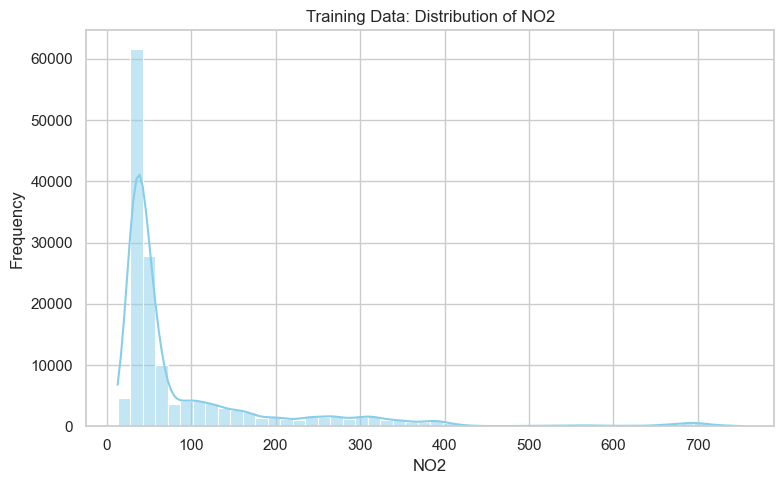

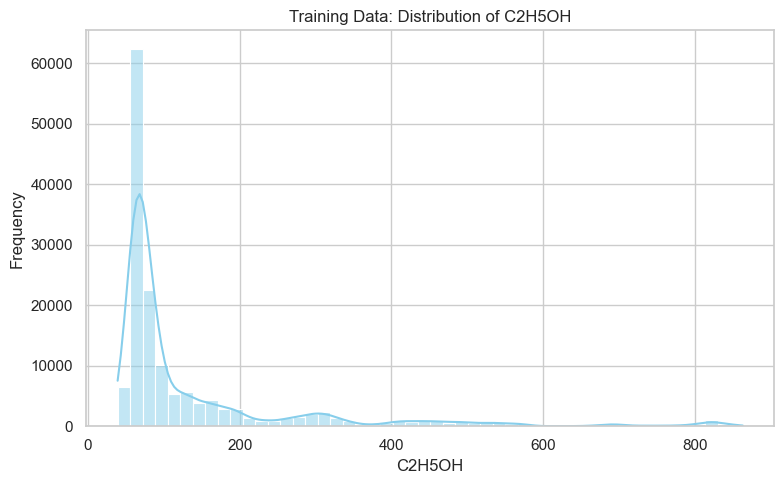

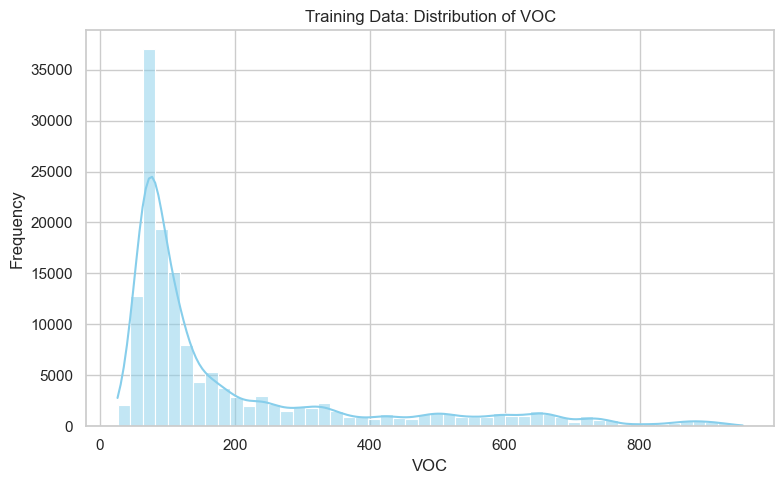

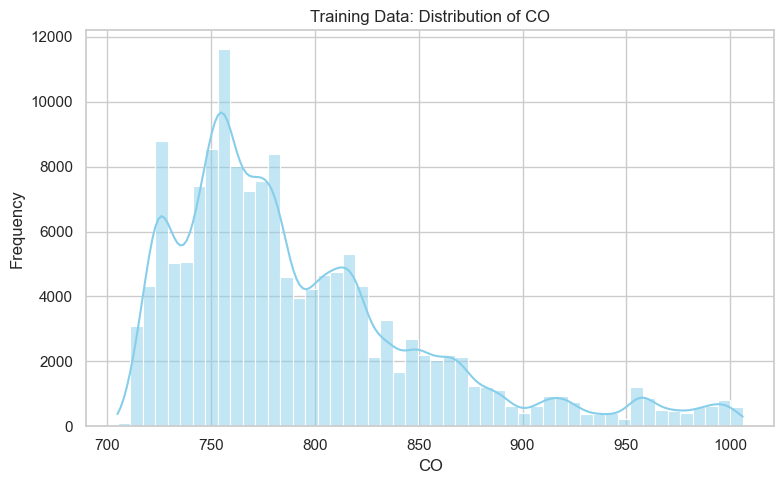

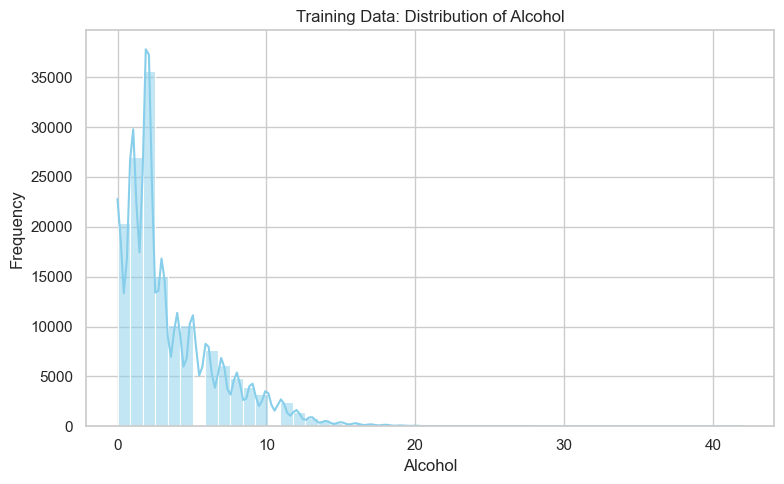

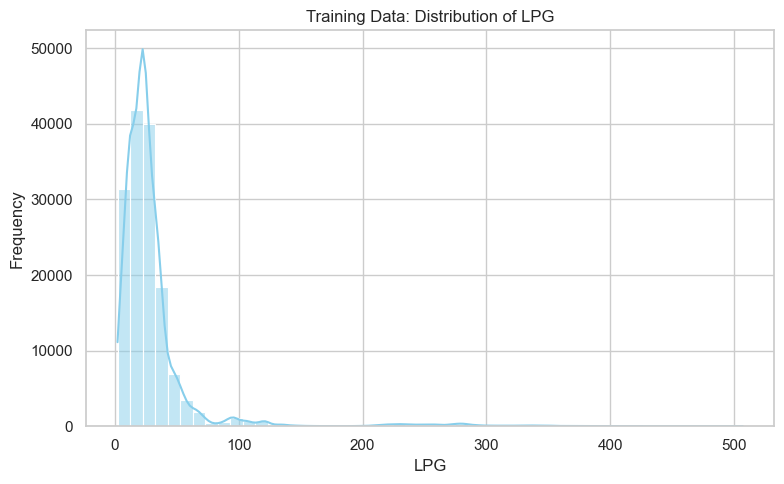

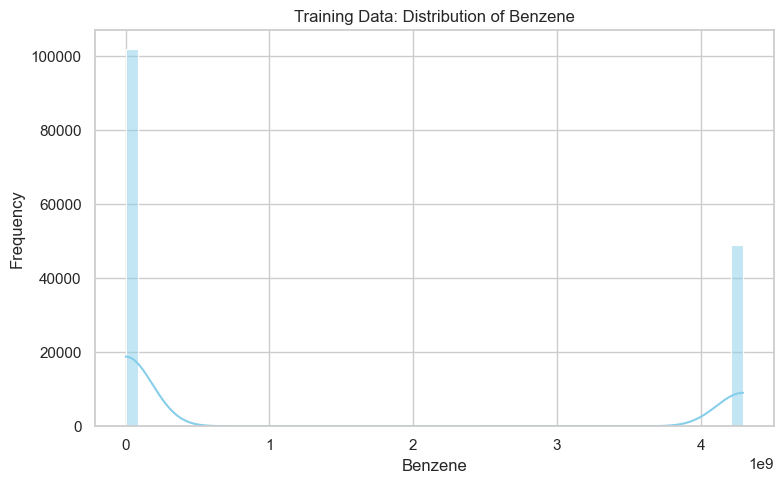

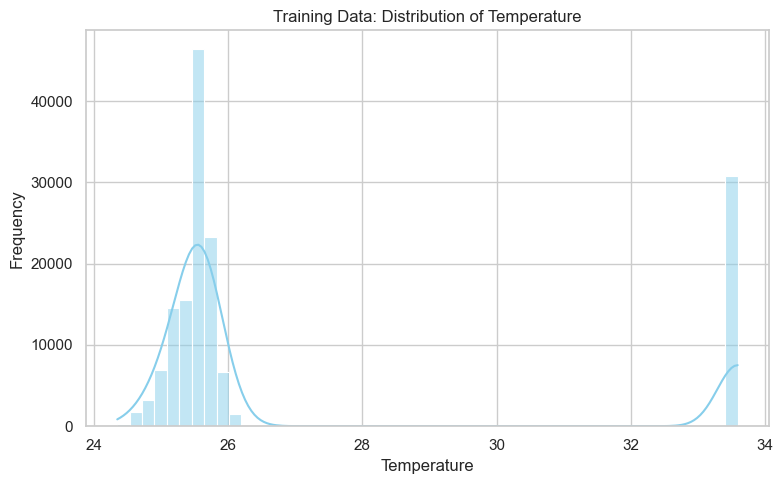

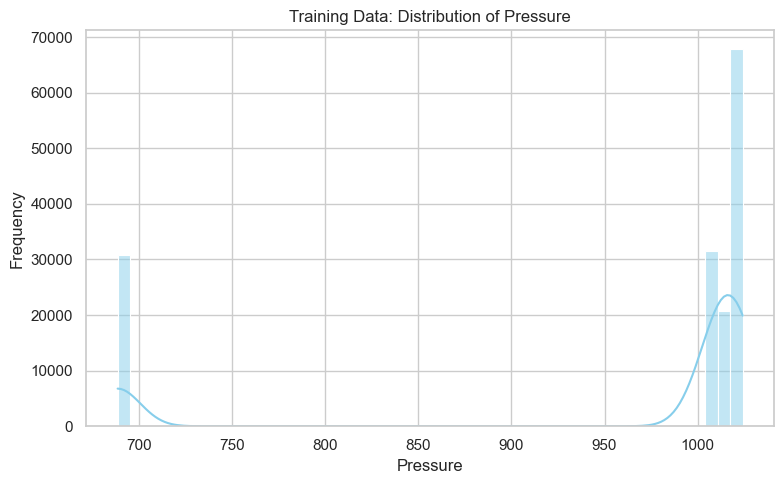

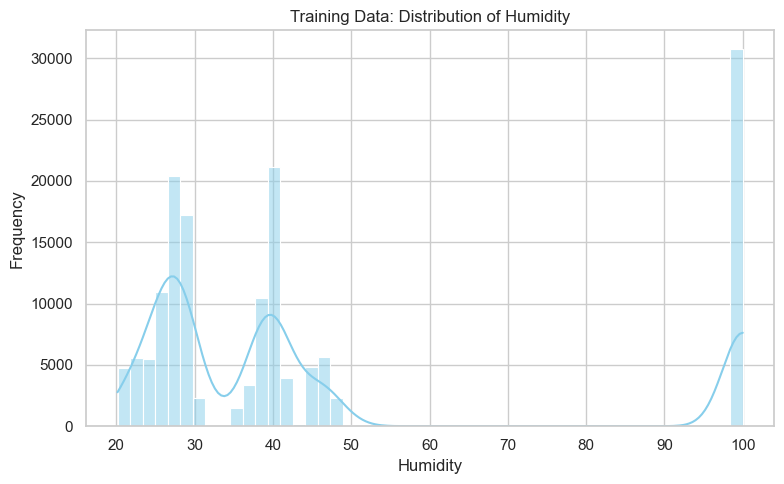

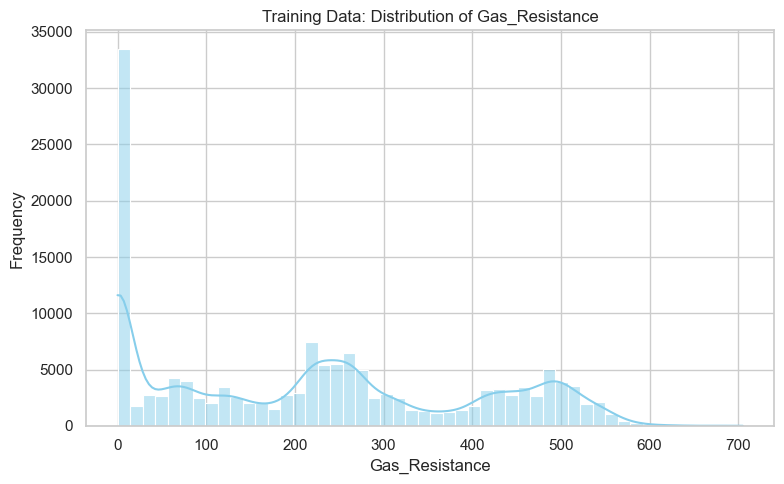

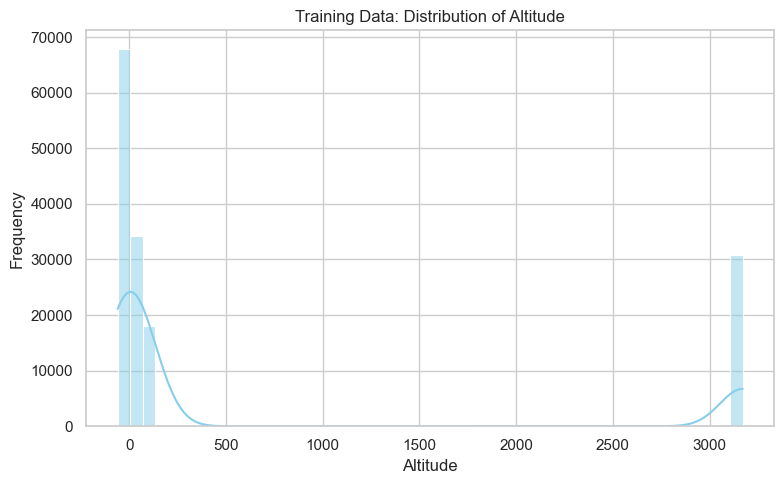

In [33]:
# Set a style for prettier plots
sns.set_theme(style="whitegrid")

# Plot distributions for training data
for feature in sensor_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(aggregated_training[feature], kde=True, bins=50, color='skyblue')
    plt.title(f"Training Data: Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

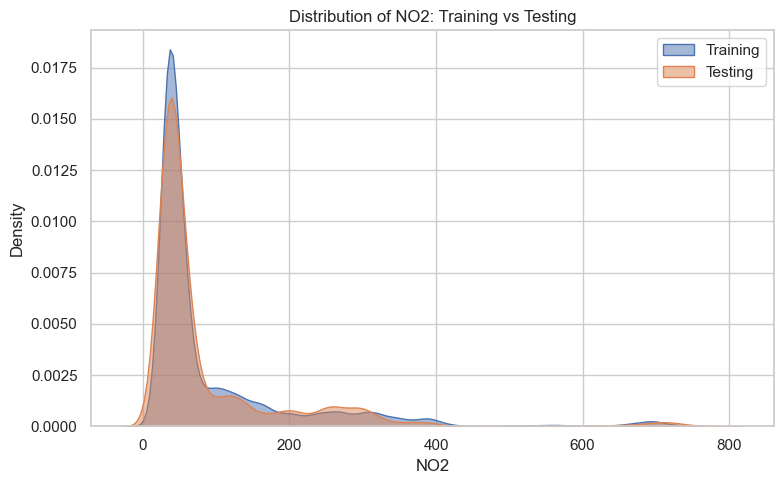

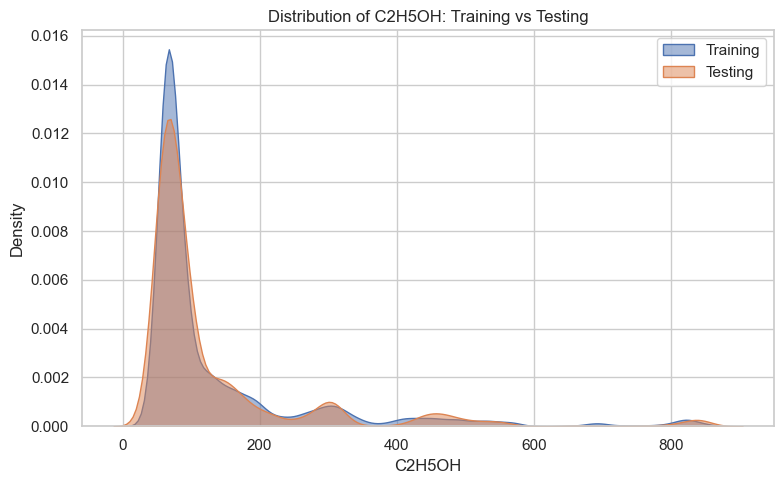

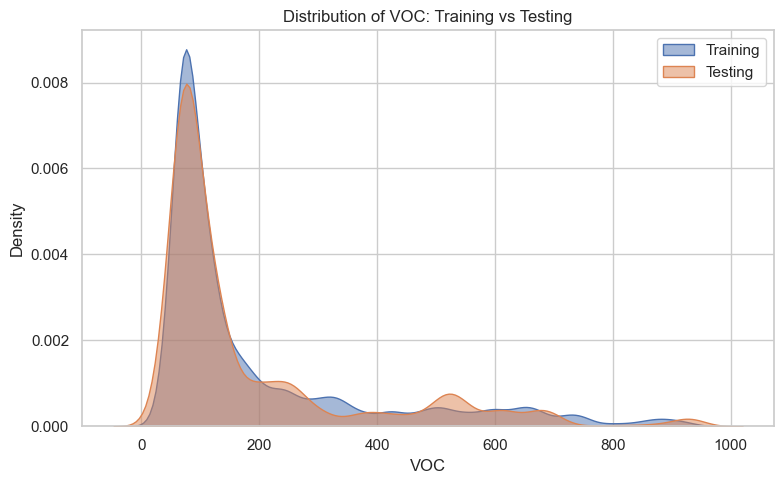

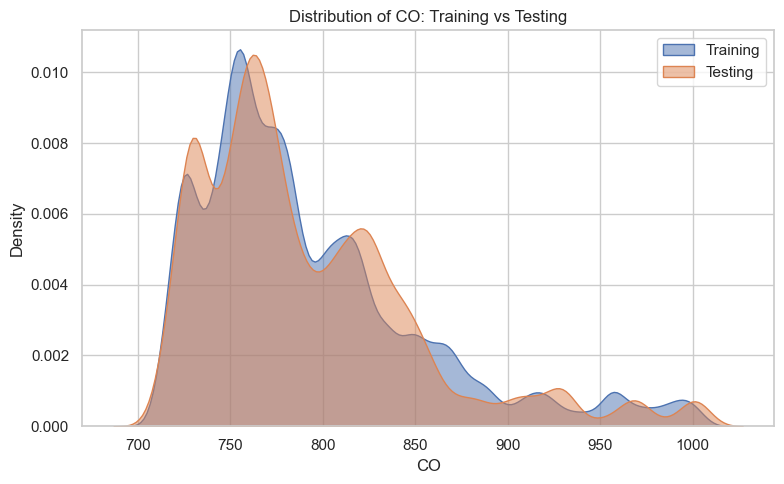

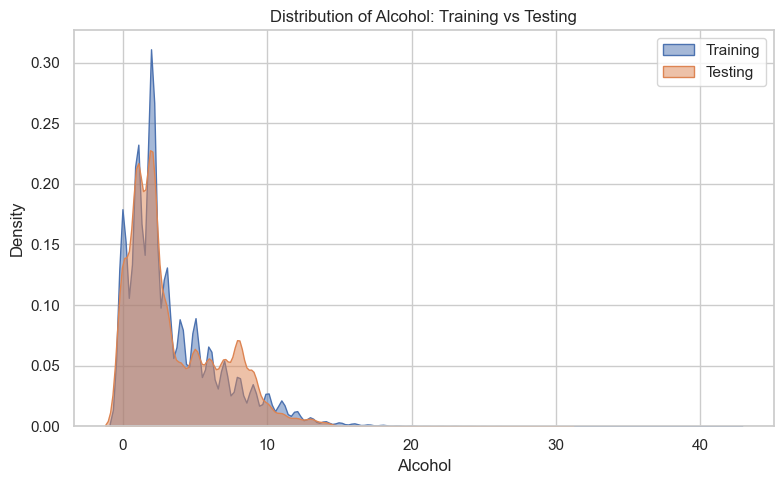

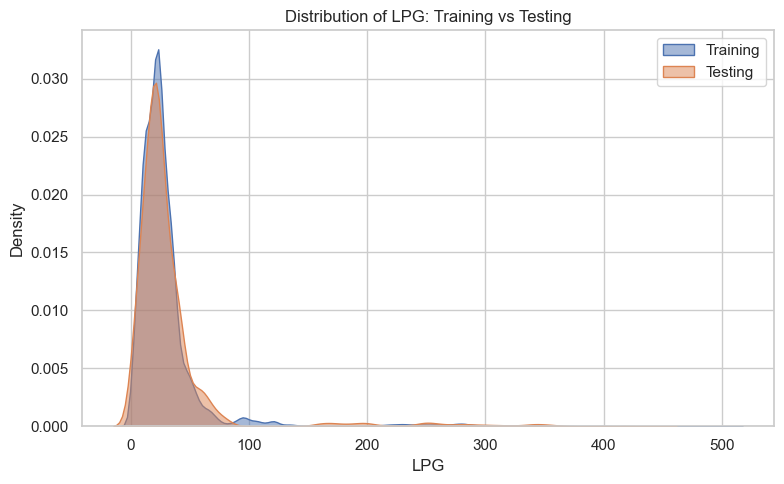

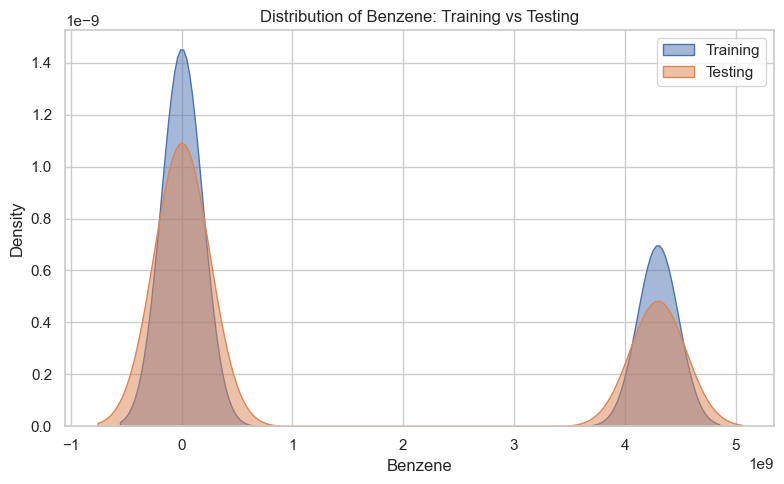

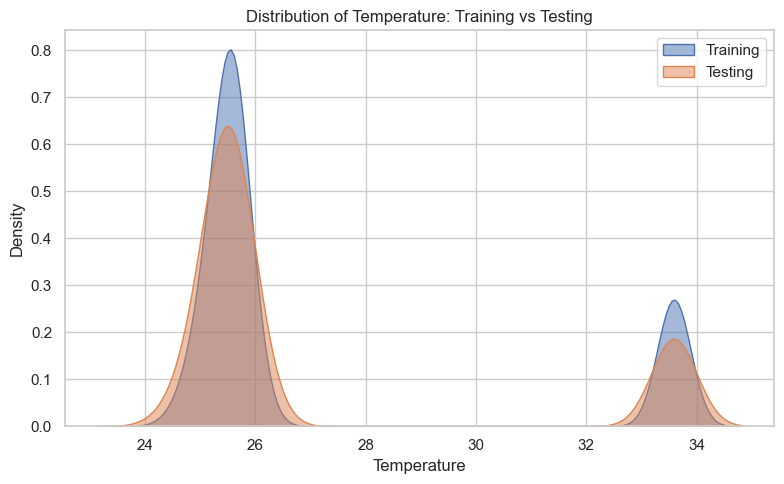

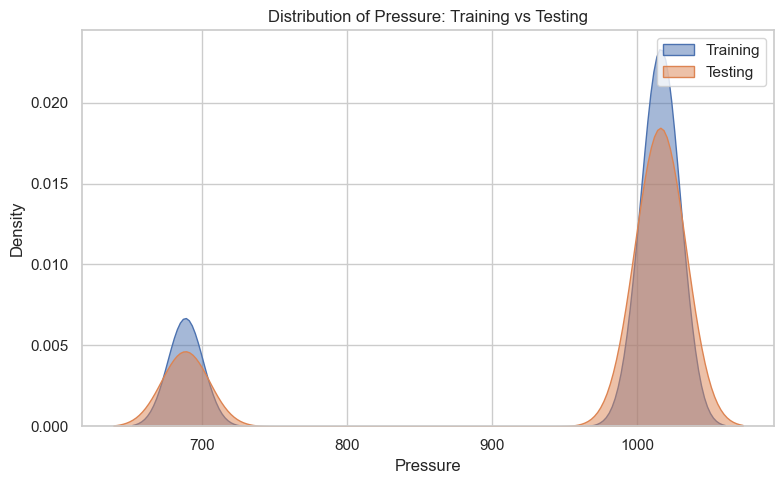

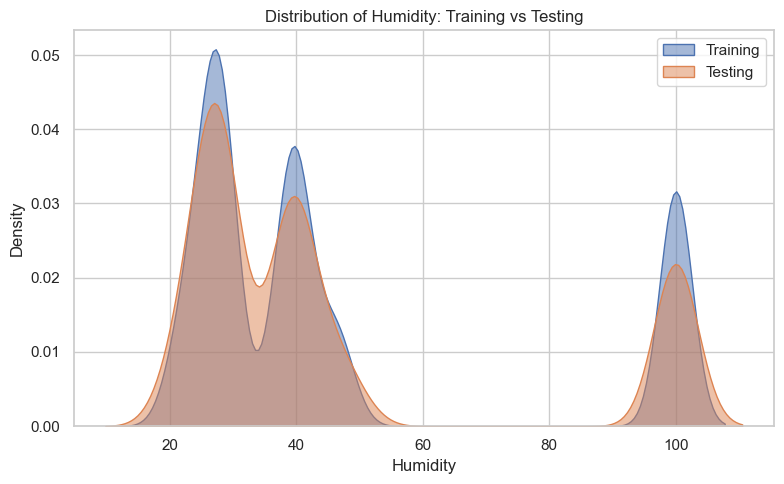

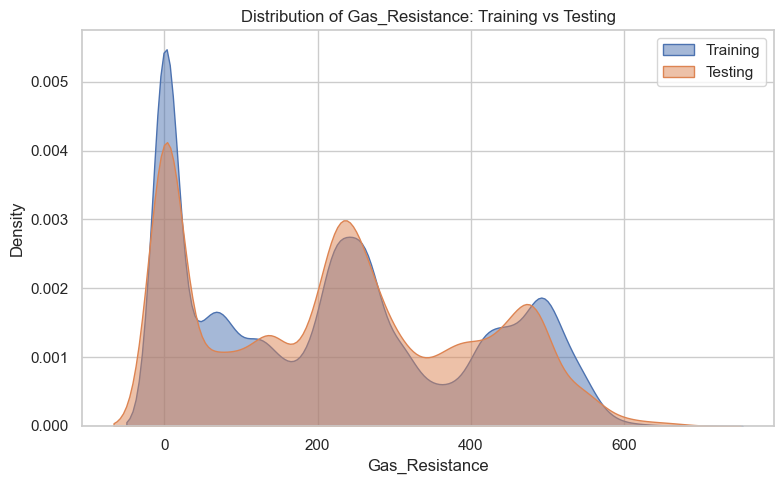

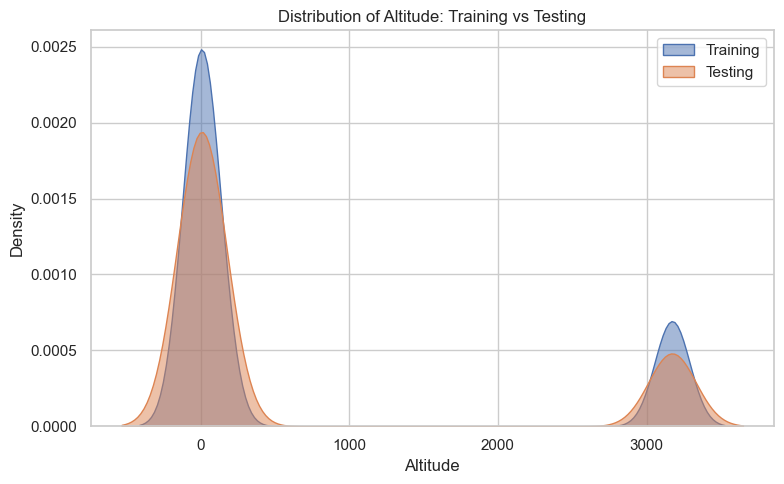

In [34]:
for feature in sensor_columns:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(aggregated_training[feature], label="Training", fill=True, alpha=0.5)
    sns.kdeplot(aggregated_testing[feature], label="Testing", fill=True, alpha=0.5)
    plt.title(f"Distribution of {feature}: Training vs Testing")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [36]:
for feature in sensor_columns:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(aggregated_training[feature], label="Training", fill=True, alpha=0.5)
    sns.kdeplot(aggregated_testing[feature], label="Testing", fill=True, alpha=0.5)
    plt.title(f"Distribution of {feature}: Training vs Testing")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/Users/derre/Documents/workspace/smell-net/data_stats/feature_distribution_train_vs_test_{feature}.png", dpi=300)
    plt.close()

In [93]:
training_category_stats = aggregated_training.groupby('category')[sensor_columns].agg(['mean', 'std']).round(3)
testing_category_stats = aggregated_testing.groupby('category')[sensor_columns].agg(['mean', 'std']).round(3)

sns.set_theme(style="whitegrid")

for feature in sensor_columns:
    # Prepare data
    means = training_category_stats[feature]['mean']
    stds = training_category_stats[feature]['std']
    
    categories = means.index.tolist()
    mean_values = means.values
    std_values = stds.values
    
    # Create plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=categories, 
        y=mean_values, 
        palette="muted"
    )

    # Add error bars manually
    plt.errorbar(
        x=range(len(categories)), 
        y=mean_values, 
        yerr=std_values, 
        fmt='none', 
        c='black', 
        capsize=5
    )

    plt.title(f"Mean {feature} per Category (Training Data)", fontsize=16)
    plt.xlabel("Category", fontsize=14)
    plt.ylabel(f"Mean {feature} Value", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f"/Users/derre/Documents/workspace/smell-net/data_stats/feature_distributions_category/{feature}_mean_per_category.png", dpi=300)
    plt.close()

/var/folders/21/8_pbj03n215931x7t073wcc40000gn/T/ipykernel_85905/2491628127.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/21/8_pbj03n215931x7t073wcc40000gn/T/ipykernel_85905/2491628127.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/21/8_pbj03n215931x7t073wcc40000gn/T/ipykernel_85905/2491628127.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/21/8_pbj03n215931x7t073wcc40000gn/T/ipykernel_85905/2491628127.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

In [94]:
sns.set_theme(style="whitegrid")

for feature in sensor_columns:
    plt.figure(figsize=(10, 6))
    
    # Plot one KDE per category
    for category in aggregated_training['category'].dropna().unique():
        subset = aggregated_training[aggregated_training['category'] == category]
        sns.kdeplot(
            subset[feature], 
            label=category, 
            fill=True, 
            alpha=0.3
        )
    
    plt.title(f"Training Data: {feature} Distribution by Category", fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(title="Category", fontsize=10)
    plt.tight_layout()
    plt.savefig(f"/Users/derre/Documents/workspace/smell-net/data_stats/feature_distributions_category/{feature}_kde_by_category.png", dpi=300)
    plt.close()

In [56]:
# Randomly pick a few file_ids
sampled_files = random.sample(list(aggregated_training['file_id'].unique()), 5)

for file_id in sampled_files:
    df = aggregated_training[aggregated_training['file_id'] == file_id].copy()

    # Create subplots
    fig, axs = plt.subplots(6, 2, figsize=(16, 12))  # 6 rows × 2 columns
    axs = axs.flatten()

    for i, col in enumerate(sensor_columns):
        axs[i].plot(df['time_step'], df[col])
        axs[i].set_title(f"{col} over Time")
        axs[i].set_xlabel("Time Step")
        axs[i].set_ylabel(col)  # Label with sensor name (real units)

    plt.suptitle(f"Raw Time Series per Feature: {file_id}", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"/Users/derre/Documents/workspace/smell-net/data_stats/time_series_analysis/{file_id}_timeseries.png", dpi=300)
    plt.close()

In [ ]:
# 1. Compute correlation matrix
correlation_matrix = aggregated_training[sensor_columns].corr()

# 2. Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            vmin=-1, vmax=1,
            square=True,
            cbar_kws={"shrink": 0.8})

plt.title("Sensor Feature Correlation Matrix", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig(f"/Users/derre/Documents/workspace/smell-net/data_stats/feature_correlation.png", dpi=300)
plt.close()

In [76]:
X_train = aggregated_training[sensor_columns]

# Standardize features before PCA (very important!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

print(f"Explained variance ratios: {pca.explained_variance_ratio_}")

# Plot
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1],
    hue=aggregated_training['ingredient'],
    palette='tab20', 
    s=10,
    legend='full'
)
plt.title("PCA of Sensor Data (Training Set)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Customize the legend
plt.legend(
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    borderaxespad=0.,
    ncol=2,                      # <-- Put legend into 2 columns
    fontsize='small',             # <-- Smaller font size
    title="Ingredient",           # <-- Nice legend title
    title_fontsize='medium'        # <-- Title font slightly bigger
)
# plt.show()
plt.savefig(f"/Users/derre/Documents/workspace/smell-net/data_stats/PCA_sensor_data.png", dpi=300)
plt.close()

Explained variance ratios: [0.39145314 0.34491947]


['Herbs' 'Fruits' 'Spices' 'Vegetables' 'Nuts' nan]


ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by StandardScaler.

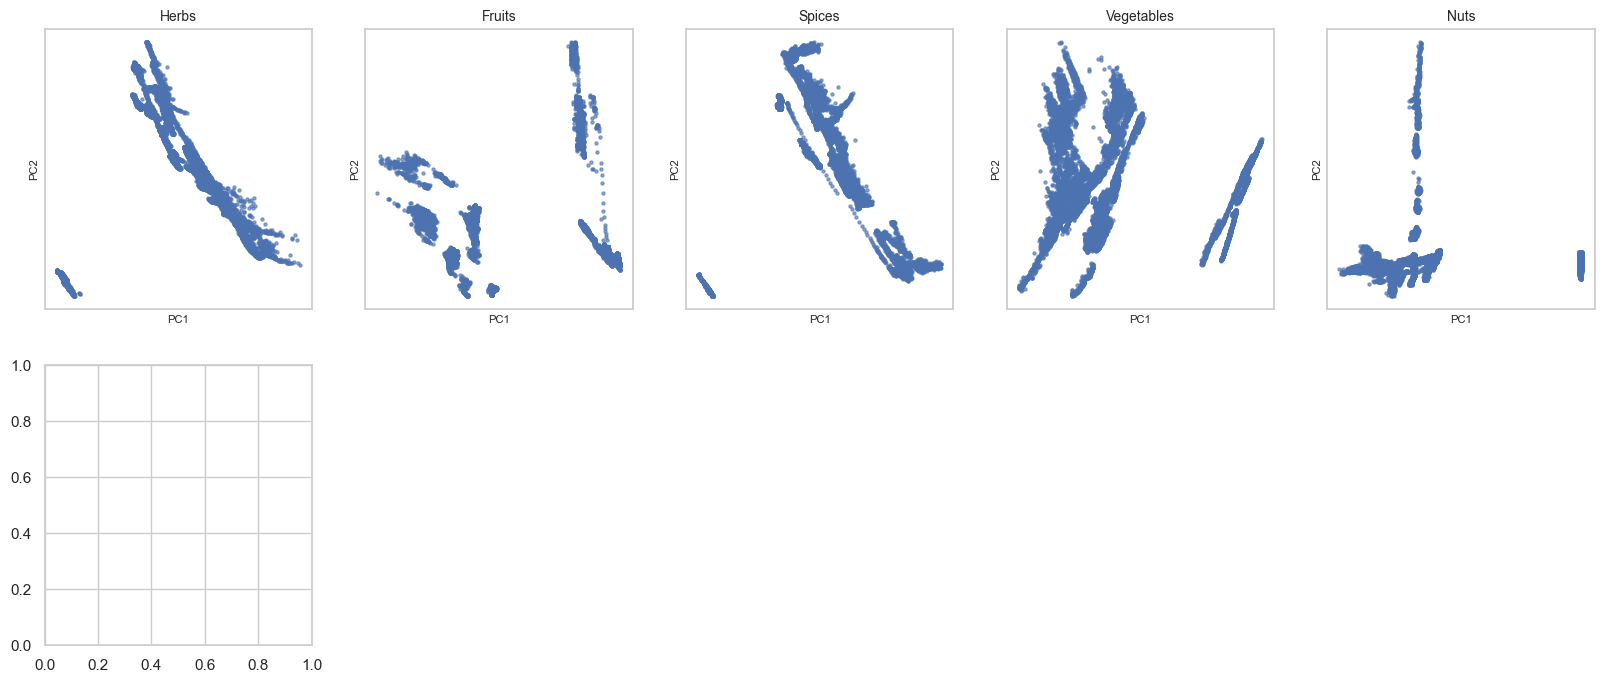

In [ ]:
# Set up the grid for subplots
categories = aggregated_training['category'].unique()
n_categories = len(categories)

n_cols = 5  # You can change this
n_rows = (n_categories + n_cols - 1) // n_cols  # Ceiling division

plt.figure(figsize=(4 * n_cols, 4 * n_rows))



for i, category in enumerate(categories):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Select data for this category
    group_df = aggregated_training[aggregated_training['category'] == category]
    X = group_df[sensor_columns]
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Scatter plot
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.6)
    plt.title(category, fontsize=10)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('PC1', fontsize=8)
    plt.ylabel('PC2', fontsize=8)

plt.tight_layout()
plt.show()

In [86]:
missing_category_rows = aggregated_training[aggregated_training['category'].isna()]

# Display them
print(missing_category_rows)

# Optional: check how many
print(f"Number of rows with missing category: {len(missing_category_rows)}")

       NO2  C2H5OH  VOC   CO  Alcohol  LPG  Benzene  Temperature  Pressure  \
30964   64      87  143  737        0   14        0        25.55   1020.46   
30965   64      86  144  738        0   14        0        25.55   1020.47   
30966   65      86  145  740        0   14        0        25.55   1020.47   
30967   64      87  145  741        0   16        0        25.55   1020.47   
30968   64      87  145  741        0   14        0        25.55   1020.46   
...    ...     ...  ...  ...      ...  ...      ...          ...       ...   
33831   66      89  148  749        0   12        0        25.56   1020.47   
33832   66      89  148  748        0   13        0        25.56   1020.47   
33833   67      88  148  749        0   13        0        25.56   1020.46   
33834   67      89  148  749        0   13        0        25.56   1020.46   
33835   67      89  148  749        0   13        0        25.56   1020.46   

       Humidity  Gas_Resistance  Altitude ingredient       file